In [61]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd
# import random
# import torch
# from torch import nn, optim
# from torch.utils.data import DataLoader, Dataset
# from torch.utils.tensorboard import SummaryWriter
# from torch.cuda.amp import GradScaler, autocast

# import cv2

# import albumentations
# from albumentations.pytorch import ToTensorV2

# from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

# from tqdm import tqdm
# import argparse
# import os, sys, yaml

# sys.path.append('/workspace/siim-rsna-2021')
# from src.logger import setup_logger, LOGGER
# from src.meter import mAPMeter, AUCMeter, APMeter, AverageValueMeter
# from src.utils import plot_sample_images

# import neptune.new as neptune
# import pydicom

# import time
# from contextlib import contextmanager

# import timm

# import warnings

# target_columns = [
#     "Negative for Pneumonia", "Typical Appearance", "Indeterminate Appearance", "Atypical Appearance"
# ]


# @contextmanager
# def timer(name):
#     t0 = time.time()
#     yield
#     print(f'[{name}] done in {time.time() - t0:.0f} s')


# def seed_torch(seed=516):
#     random.seed(seed)
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True


# def ousm_loss(error, k=2):
#     # ousm, drop large k sample
#     bs = error.shape[0]
#     if len(error.shape) == 2:
#         error = error.mean(1)
#     _, idxs = error.topk(bs - k, largest=False)
#     error = error.index_select(0, idxs)
#     return error


# # Freeze batchnorm 2d
# def set_bn_eval(m):
#     classname = m.__class__.__name__
#     if classname.find('BatchNorm2d') != -1:
#         m.eval()


# # =============================================================================
# # Model
# # =============================================================================

# class Net(nn.Module):
#     def __init__(self, name="resnest101e"):
#         super(Net, self).__init__()
#         self.model = timm.create_model(name, pretrained=True, num_classes=len(target_columns))

#     def forward(self, x):
#         x = self.model(x).squeeze(-1)
#         return x

# # =============================================================================
# # Dataset
# # =============================================================================

# class CustomDataset(Dataset):
#     def __init__(self,
#                  df,
#                  image_size,
#                  transform=None,
#                  mode="train",
#                  clahe=False,
#                  mix=False,
#                  ):

#         self.df = df.reset_index(drop=True)
#         self.image_size = image_size
#         self.transform = transform

#         self.mode = mode
#         self.clahe = clahe
#         self.mix = mix
#         if self.clahe or self.mix:
#             self.clahe_transform = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(16, 16))

#         self.cols = target_columns

#     def __len__(self):
#         return self.df.shape[0]

#     def __getitem__(self, index):
#         row = self.df.iloc[index]

#         image = pydicom.read_file(row.dicom_path).pixel_array

#         # preprocessing
#         image = (image - image.min()) / (image.max() - image.min())

#         image = cv2.cvtColor(image.astype(np.float32), cv2.COLOR_GRAY2RGB)


#         if self.clahe:
#             single_channel = images[:, :, 0].astype(np.uint8)
#             single_channel = self.clahe_transform.apply(single_channel)
#             images = np.array([
#                 single_channel,
#                 single_channel,
#                 single_channel
#             ]).transpose(1, 2, 0)
#         elif self.mix:
#             single_channel = images[:, :, 0].astype(np.uint8)
#             clahe_channel = self.clahe_transform.apply(single_channel)
#             hist_channel = cv2.equalizeHist(single_channel)
#             images = np.array([
#                 single_channel,
#                 clahe_channel,
#                 hist_channel
#             ]).transpose(1, 2, 0)

#         if self.transform is not None:
#             if self.mode == "train":
#                 image = image * 255
#                 images = self.transform(image=image.astype(np.uint8))['image']
#             else:
#                 images = self.transform(image=image)['image']
#         else:
#             images = images.transpose(2, 0, 1)


#         if self.mode == "train" or self.mode == "val":
#             label = row[self.cols].values.astype(np.float16)
#             return {
#                 "image": torch.tensor(images, dtype=torch.float),
#                 # "image": images,
#                 "target": torch.tensor(label, dtype=torch.float)
#             }
#         else:
#             return {
#                 "image": torch.tensor(images, dtype=torch.float)
#             }

# #
# # def get_train_transforms(image_size):
# #     return albumentations.Compose([
# #         albumentations.Transpose(p=0.5),
# #         albumentations.VerticalFlip(p=0.5),
# #         albumentations.HorizontalFlip(p=0.5),
# #         albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,
# #                                                 brightness_by_max=False, p=0.5),
# #         albumentations.Blur(blur_limit=7, p=0.5),
# #         # albumentations.HueSaturationValue(p=0.5),
# #         albumentations.CenterCrop(540, 540, p=1),
# #         albumentations.Resize(image_size, image_size),
# #         # albumentations.RandomResizedCrop(height=image_size, width=image_size, scale=(0.08, 1)),
# #         albumentations.CoarseDropout(max_holes=3, max_height=50, max_width=50),
# #         ToTensorV2()
# #     ])
# #
# #
# # def get_val_transforms(image_size):
# #     return albumentations.Compose([
# #         albumentations.CenterCrop(540, 540, p=1),
# #         albumentations.Resize(image_size, image_size),
# #         # albumentations.RandomResizedCrop(height=image_size, width=image_size, scale=(0.08, 1)),
# #         ToTensorV2()
# #     ], p=1.0)


# def get_train_transforms(image_size):
#     return albumentations.Compose([
#            albumentations.ShiftScaleRotate(p=0.5),
#            albumentations.RandomResizedCrop(image_size, image_size, scale=(0.7, 1), p=1),
#            albumentations.HorizontalFlip(p=0.5),
#            albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
#            albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
#         #    albumentations.CLAHE(clip_limit=(1, 4), p=0.5),
#            albumentations.OneOf([
#                albumentations.OpticalDistortion(distort_limit=1.0),
#                albumentations.GridDistortion(num_steps=5, distort_limit=1.),
#                albumentations.ElasticTransform(alpha=3),
#            ], p=0.2),
#            albumentations.OneOf([
#                albumentations.GaussNoise(var_limit=[10, 50]),
#                albumentations.GaussianBlur(),
#                albumentations.MotionBlur(),
#             #    albumentations.MedianBlur(),
#            ], p=0.2),
#           albumentations.Resize(image_size, image_size),
#           albumentations.OneOf([
#               albumentations.augmentations.transforms.JpegCompression(),
#               albumentations.augmentations.transforms.Downscale(scale_min=0.1, scale_max=0.15),
#           ], p=0.2),
#           albumentations.imgaug.transforms.IAAPiecewiseAffine(p=0.2),
#           albumentations.imgaug.transforms.IAASharpen(p=0.2),
#           albumentations.Cutout(max_h_size=int(image_size * 0.1), max_w_size=int(image_size * 0.1), num_holes=5, p=0.5),
# #           albumentations.Normalize(
# #               mean=[0.485, 0.456, 0.406],
# #               std=[0.229, 0.224, 0.225],
# #           ),
#           ToTensorV2(p=1)
# ])



# def get_val_transforms(image_size):
#     return albumentations.Compose([
#         albumentations.Resize(image_size, image_size),
# #         albumentations.Normalize(
# #             mean=[0.485, 0.456, 0.406],
# #             std=[0.229, 0.224, 0.225],
# #         ),
#         ToTensorV2(p=1)
# ])

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast

import cv2

import albumentations
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

from tqdm import tqdm
import argparse
import os, sys, yaml

sys.path.append('/workspace/siim-rsna-2021')
from src.logger import setup_logger, LOGGER
from src.meter import mAPMeter, AUCMeter, APMeter, AverageValueMeter
from src.utils import plot_sample_images

import neptune.new as neptune
import pydicom

import time
from contextlib import contextmanager

import timm

import warnings

target_columns = [
    "Negative for Pneumonia", "Typical Appearance", "Indeterminate Appearance", "Atypical Appearance"
]


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')


def seed_torch(seed=516):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def ousm_loss(error, k=2):
    # ousm, drop large k sample
    bs = error.shape[0]
    if len(error.shape) == 2:
        error = error.mean(1)
    _, idxs = error.topk(bs - k, largest=False)
    error = error.index_select(0, idxs)
    return error


# Freeze batchnorm 2d
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        m.eval()


# =============================================================================
# Model
# =============================================================================

class Net(nn.Module):
    def __init__(self, name="resnest101e"):
        super(Net, self).__init__()
        self.model = timm.create_model(name, pretrained=True, num_classes=len(target_columns))

    def forward(self, x):
        x = self.model(x).squeeze(-1)
        return x

# =============================================================================
# Dataset
# =============================================================================

class CustomDataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 transform=None,
                 mode="train",
                 clahe=False,
                 mix=False,
                 ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.transform = transform

        self.mode = mode
        self.clahe = clahe
        self.mix = mix
        if self.clahe or self.mix:
            self.clahe_transform = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(16, 16))

        self.cols = target_columns

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]

        image = pydicom.read_file(row.dicom_path).pixel_array

        # preprocessing
        image = (image - image.min()) / (image.max() - image.min())

        image = cv2.cvtColor(image.astype(np.float32), cv2.COLOR_GRAY2RGB)


        if self.clahe:
            single_channel = images[:, :, 0].astype(np.uint8)
            single_channel = self.clahe_transform.apply(single_channel)
            images = np.array([
                single_channel,
                single_channel,
                single_channel
            ]).transpose(1, 2, 0)
        elif self.mix:
            single_channel = images[:, :, 0].astype(np.uint8)
            clahe_channel = self.clahe_transform.apply(single_channel)
            hist_channel = cv2.equalizeHist(single_channel)
            images = np.array([
                single_channel,
                clahe_channel,
                hist_channel
            ]).transpose(1, 2, 0)

        if self.transform is not None:
            image = image * 255
            images = self.transform(image=image.astype(np.uint8))['image']
#             images = self.transform(image=image)['image']
        else:
            images = images.transpose(2, 0, 1)


        if self.mode == "train":
            label = row[self.cols].values.astype(np.float16)
            return {
                "image": torch.tensor(images, dtype=torch.float),
#                 "image": images,
                "target": torch.tensor(label, dtype=torch.float),
                "i": image
            }
        else:
            return {
                "image": torch.tensor(images, dtype=torch.float)
            }



def get_train_transforms(image_size):
    return albumentations.Compose([
           albumentations.ShiftScaleRotate(p=0.5),
           albumentations.RandomResizedCrop(image_size, image_size, scale=(0.7, 1), p=1),
           albumentations.HorizontalFlip(p=0.5),
           albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
           albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
        #    albumentations.CLAHE(clip_limit=(1, 4), p=0.5),
           albumentations.OneOf([
               albumentations.OpticalDistortion(distort_limit=1.0),
               albumentations.GridDistortion(num_steps=5, distort_limit=1.),
               albumentations.ElasticTransform(alpha=3),
           ], p=0.2),
           albumentations.OneOf([
               albumentations.GaussNoise(var_limit=[10, 50]),
               albumentations.GaussianBlur(),
               albumentations.MotionBlur(),
            #    albumentations.MedianBlur(),
           ], p=0.2),
          albumentations.Resize(image_size, image_size),
          albumentations.OneOf([
              albumentations.augmentations.transforms.JpegCompression(),
              albumentations.augmentations.transforms.Downscale(scale_min=0.1, scale_max=0.15),
          ], p=0.2),
          albumentations.imgaug.transforms.IAAPiecewiseAffine(p=0.2),
          albumentations.imgaug.transforms.IAASharpen(p=0.2),
          albumentations.Cutout(max_h_size=int(image_size * 0.1), max_w_size=int(image_size * 0.1), num_holes=5, p=0.5),
          albumentations.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          ),
          ToTensorV2(p=1)
])



def get_val_transforms(image_size):
    return albumentations.Compose([
        albumentations.Resize(image_size, image_size),
#         albumentations.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
        ToTensorV2(p=1)
])



In [131]:
df = pd.read_csv('/workspace/data/df_train_study_level.csv')

In [132]:
val_dataset = CustomDataset(df=df, image_size=512, clahe=False, mix=False,
                            transform=get_val_transforms(512), mode="train")

# train_dataset = CustomDataset(df=df, image_size=512, clahe=False, mix=False,
#                             transform=get_train_transforms(512), mode="train")
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
#                             pin_memory=False, num_workers=n_workers, drop_last=False)

In [133]:
data = val_dataset[0]["i"]

<ipython-input-130-6a7cd91b8e55>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "image": torch.tensor(images, dtype=torch.float),


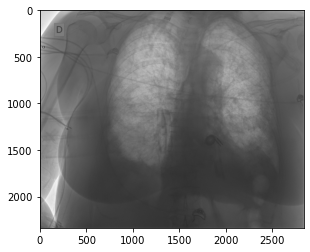

In [134]:
plt.figure()
plt.imshow(data.astype(np.uint8))
plt.show()

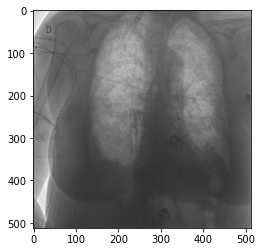

In [135]:
plt.figure()
plt.imshow(get_val_transforms(512)(image=data.astype(np.uint8))["image"].numpy().transpose(1, 2, 0))
plt.show()

<ipython-input-130-6a7cd91b8e55>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "image": torch.tensor(images, dtype=torch.float),


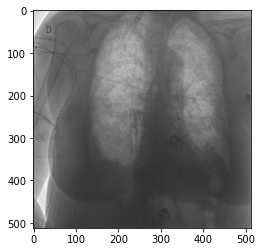

In [145]:
plt.figure()
plt.imshow(val_dataset[0]["image"].numpy().transpose(1, 2, 0).astype(np.uint8))
plt.show()

In [141]:
val_dataset[0]["image"].max()

<ipython-input-130-6a7cd91b8e55>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "image": torch.tensor(images, dtype=torch.float),


tensor(255.)

In [142]:
val_dataset[0]["image"].numpy().transpose(1, 2, 0)

<ipython-input-130-6a7cd91b8e55>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "image": torch.tensor(images, dtype=torch.float),


array([[[233., 233., 233.],
        [225., 225., 225.],
        [223., 223., 223.],
        ...,
        [176., 176., 176.],
        [180., 180., 180.],
        [179., 179., 179.]],

       [[222., 222., 222.],
        [217., 217., 217.],
        [218., 218., 218.],
        ...,
        [170., 170., 170.],
        [171., 171., 171.],
        [176., 176., 176.]],

       [[223., 223., 223.],
        [218., 218., 218.],
        [213., 213., 213.],
        ...,
        [167., 167., 167.],
        [169., 169., 169.],
        [175., 175., 175.]],

       ...,

       [[104., 104., 104.],
        [ 98.,  98.,  98.],
        [ 96.,  96.,  96.],
        ...,
        [119., 119., 119.],
        [123., 123., 123.],
        [132., 132., 132.]],

       [[100., 100., 100.],
        [ 98.,  98.,  98.],
        [ 91.,  91.,  91.],
        ...,
        [122., 122., 122.],
        [123., 123., 123.],
        [135., 135., 135.]],

       [[100., 100., 100.],
        [ 94.,  94.,  94.],
        [ 97.,  

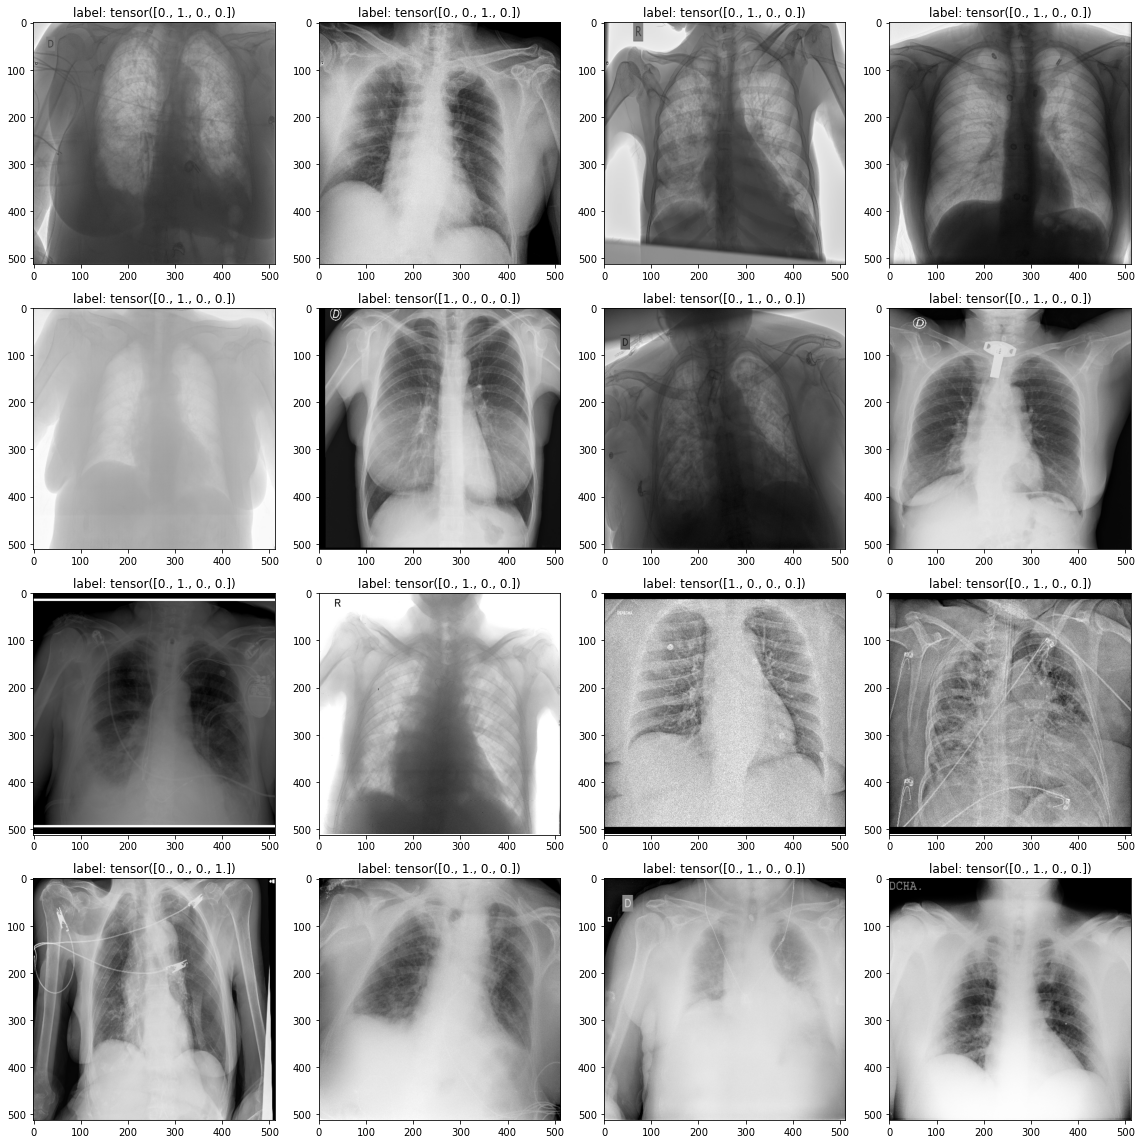

In [129]:
normalize = None#"imagenet"
dataset = val_dataset
n_img = 16


plt.figure(figsize=(16, 16))
for i in range(n_img):
    data = dataset[i]
    if normalize == "+":
        img = data["image"].numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) \
              + np.array([0.485, 0.456, 0.406])
    else:
        img = data["image"].numpy().transpose(1, 2, 0)
    label = data["target"]
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f"label: {label}")
plt.tight_layout()
plt.show()
# if name:
#     if ".png" in name:
#         plt.savefig(os.path.join(save_path, f"{str(name)}.png"))
#     else:
#         plt.savefig(os.path.join(save_path, str(name)))
# else:
#     plt.savefig(os.path.join(save_path, "sample_image.png"))
# plt.close()

<ipython-input-62-46bac2f00b18>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "image": torch.tensor(images, dtype=torch.float),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/functional.py:788: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] f

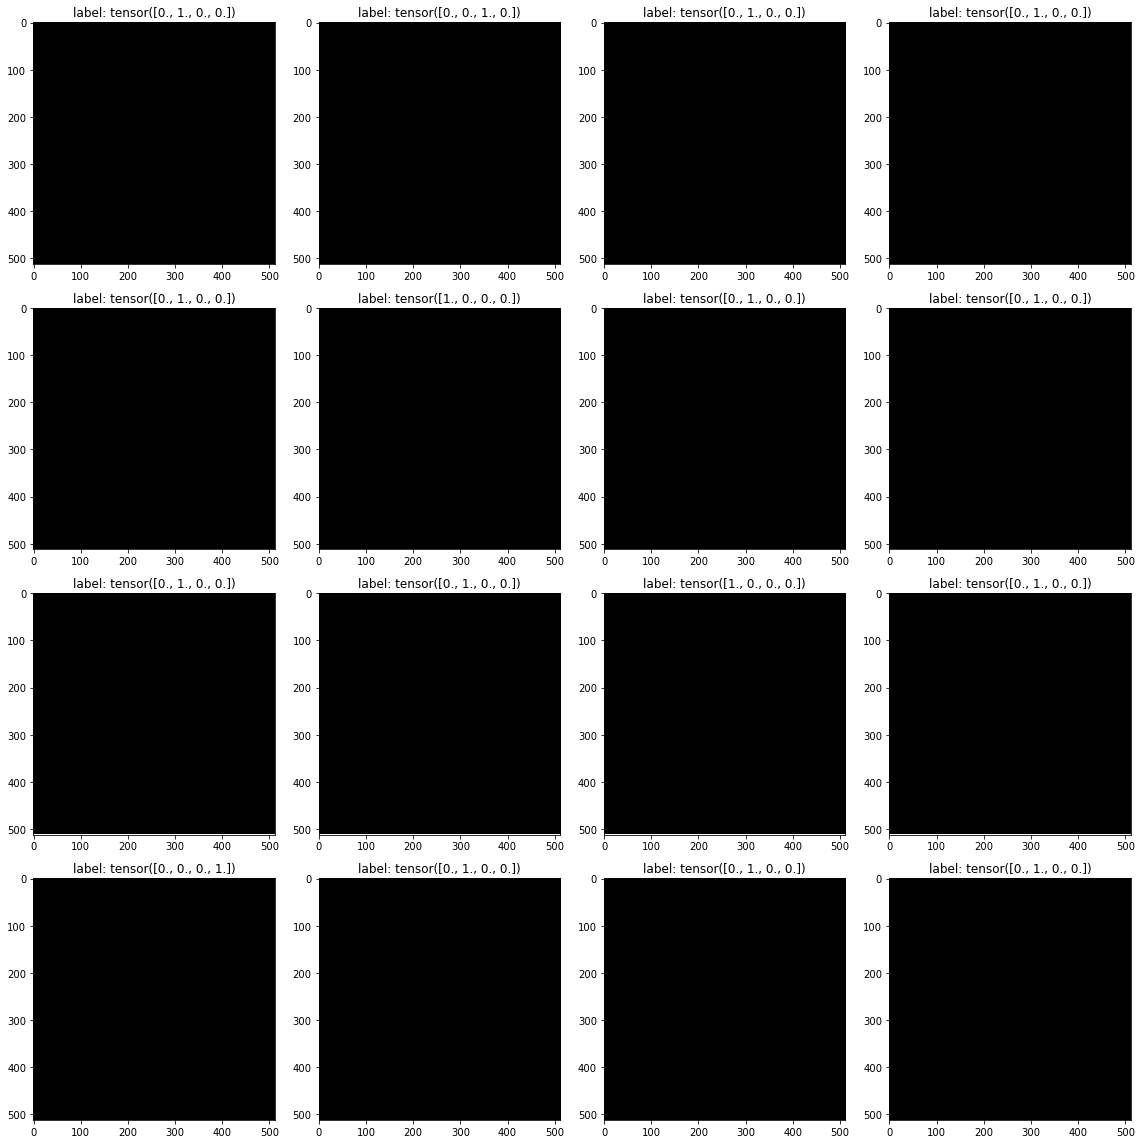

In [66]:
normalize = None #"imagenet"
dataset = train_dataset
n_img = 16


plt.figure(figsize=(16, 16))
for i in range(n_img):
    data = dataset[i]
    if normalize == "+":
        img = data["image"].numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) \
              + np.array([0.485, 0.456, 0.406])
    else:
        img = data["image"].numpy().transpose(1, 2, 0)
    label = data["target"]
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f"label: {label}")
plt.tight_layout()
plt.show()
# if name:
#     if ".png" in name:
#         plt.savefig(os.path.join(save_path, f"{str(name)}.png"))
#     else:
#         plt.savefig(os.path.join(save_path, str(name)))
# else:
#     plt.savefig(os.path.join(save_path, "sample_image.png"))
# plt.close()

In [27]:
normalize = "imagenet"
dataset = val_dataset
n_img = 16


plt.figure(figsize=(16, 16))
for i in range(n_img):
    data = dataset[i]
    if normalize == "+":
        img = data["image"].numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) \
              + np.array([0.485, 0.456, 0.406])
    else:
        img = data["image"].numpy().transpose(1, 2, 0)
    label = data["target"]
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f"label: {label}")
plt.tight_layout()
# if name:
#     if ".png" in name:
#         plt.savefig(os.path.join(save_path, f"{str(name)}.png"))
#     else:
#         plt.savefig(os.path.join(save_path, str(name)))
# else:
plt.savefig("sample_image.png")
plt.close()

<ipython-input-22-b46c881b4f9e>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "image": torch.tensor(images, dtype=torch.float),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with 

In [33]:
image = pydicom.read_file(path_list[i]).pixel_array
image = (image - image.min()) / (image.max() - image.min())
# image = (image - image.mean()) / image.std()

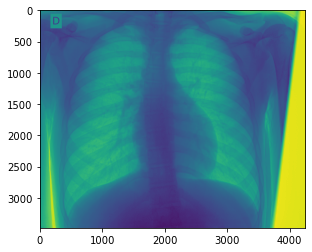

In [34]:
plt.figure()
plt.imshow(image)
plt.show()

In [35]:
image.max()

1.0